In [12]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run")
osw = pd.read_csv("triqler_input.csv", sep = "\t")

In [13]:
decoy_mapper = lambda x: x.split("_")[0]
osw["decoy"] = osw.proteins.map(decoy_mapper) == "DECOY"
osw = osw[osw["decoy"] == False] #Filter away decoy peptides and protein

In [14]:
osw_peptide_intensity_count = osw.groupby(["condition", "peptide"]).count().intensity 

# We split up between conditions because we do not want samples to partially exist in condition 1 and 2 
# and count them as full samples.

# We check which peptides has lower than count 3 i.e. one for each sample for each condition
cond_1_missing_value_peptides = osw_peptide_intensity_count[(osw_peptide_intensity_count<3) 
                              & (osw_peptide_intensity_count.index.get_level_values("condition").isin([1]))].index.get_level_values("peptide")
cond_2_missing_value_peptides = osw_peptide_intensity_count[(osw_peptide_intensity_count<3) 
                              & (osw_peptide_intensity_count.index.get_level_values("condition").isin([2]))].index.get_level_values("peptide")
osw_condition_1_missing = osw[osw.peptide.isin(cond_1_missing_value_peptides) & (osw.condition.isin([1]))]
osw_condition_2_missing = osw[osw.peptide.isin(cond_2_missing_value_peptides) & (osw.condition.isin([2]))]





In [15]:
# We create a pivot table (rows = peptides, columns = samples)
pivot_condition_1_missing = pd.pivot_table(osw_condition_1_missing, values = "intensity", index = ["condition", "peptide"], columns = "run")
pivot_condition_2_missing = pd.pivot_table(osw_condition_2_missing, values = "intensity", index = ["condition", "peptide"], columns = "run")
condition_1_cols = pivot_condition_1_missing.columns
condition_2_cols = pivot_condition_2_missing.columns
pivot_missing = pd.concat([pivot_condition_1_missing, pivot_condition_2_missing], axis = 0)

In [16]:
pivot_missing # Here we can see how the peptides are missing in each sample

run                                         002-Pedro  004-Pedro  006-Pedro  \
condition peptide                                                             
1         (UniMod:1)AENGDNEK                      NaN        NaN   7.295696   
          (UniMod:1)MNMGGSSSTAAK                  NaN   8.021383        NaN   
          (UniMod:1)MNNSGADEIGK                   NaN        NaN  43.506435   
          AC(UniMod:4)YVC(UniMod:4)GK        3.569365        NaN        NaN   
          AQLLGAWAGELLAEELR                 38.981720        NaN        NaN   
...                                               ...        ...        ...   
2         VKEDPDGEHAR                             NaN        NaN        NaN   
          VKGEWDK                                 NaN        NaN        NaN   
          VYSSTDSK                                NaN        NaN        NaN   
          YLEVVLNTLQQASQAQVDKSDYDMVDYLNELR        NaN        NaN        NaN   
          YQEQGGEASPQR                            NaN        NaN        NaN   

run                                         003-Pedro  005-Pedro  007-Pedro  
condition peptide                                                            
1         (UniMod:1)AENGDNEK                      NaN        NaN        NaN  
          (UniMod:1)MNMGGSSSTAAK                  NaN        NaN        NaN  
          (UniMod:1)MNNSGADEIGK                   NaN        NaN        NaN  
          AC(UniMod:4)YVC(UniMod:4)GK             NaN        NaN        NaN  
          AQLLGAWAGELLAEELR                       NaN        NaN        NaN  
...                                               ...        ...        ...  
2         VKEDPDGEHAR                             NaN   6.041897        NaN  
          VKGEWDK                            5.460671        NaN        NaN  
          VYSSTDSK                           5.244719        NaN        NaN  
          YLEVVLNTLQQASQAQVDKSDYDMVDYLNELR  64.575081        NaN        NaN  
          YQEQGGEASPQR                            NaN   6.094812   7.671667  

[71 rows x 6 columns]

In [17]:
# Compute mean, standard deviation and na_count
pivot_missing["mu"] = pivot_missing.mean(axis = 1)
pivot_missing["std"] = pivot_missing.std(axis = 1) 
pivot_missing["na_count"] = pivot_missing.isna().sum(axis = 1) - 3 # remove three because we do not want to count missing on both samples

# We fill na and create nan_bool, so we can hide the filled in values again, and a vals_bool so we can we 
# the non-imputed values.
osw_cond_1 = pivot_missing[pivot_missing.index.get_level_values("condition") == 1][list(condition_1_cols)]
vals_bool = ~osw_cond_1.isna()
vals_bools = vals_bool.replace(False, np.nan)
nan_bool = osw_cond_1.isna()
nan_bool = nan_bool.replace(False, np.nan)
osw_cond_1 = osw_cond_1.T.fillna(osw_cond_1.mean(axis=1)).T #row average fillna

# Keep imputed nans
osw_cond_1_imputed_mean_nans = (osw_cond_1*nan_bool).droplevel(level = "condition").melt().dropna()

# Keep values 
osw_cond_1_vals = (osw_cond_1*vals_bool).droplevel(level = "condition").melt().dropna()

# Do the same for condition 2
osw_cond_2 = pivot_missing[pivot_missing.index.get_level_values("condition") == 2][list(condition_2_cols)]
vals_bool = ~osw_cond_2.isna()
vals_bools = vals_bool.replace(False, np.nan)
nan_bool = osw_cond_2.isna()
nan_bool = nan_bool.replace(False, np.nan)
osw_cond_2 = osw_cond_2.T.fillna(osw_cond_2.mean(axis=1)).T #row average fillna
osw_cond_2_imputed_mean_nans = (osw_cond_2*nan_bool).droplevel(level = "condition").melt().dropna()
osw_cond_2_vals = (osw_cond_2*vals_bool).droplevel(level = "condition").melt().dropna()

In [18]:
bins = np.arange(0,1000,10)


In [19]:
# Create array for intensities.
osw_intensities = osw.intensity

# Create array for imputed means. 
osw_imputed_nans_with_condition_mean = pd.concat([osw_cond_1_imputed_mean_nans, osw_cond_2_imputed_mean_nans]).reset_index()

# Bin the imputed values and intensities.
osw_binned_imputed_mean_nans = pd.cut(osw_imputed_nans_with_condition_mean["value"], bins, include_lowest=True)
osw_binned_vals = pd.cut(osw_intensities, bins, include_lowest=True)

# For each bin  count(imputed) / count(intensities)
# Now each bin is an intensity range and each ratio is the fraction of missing value for that intensity.
osw_binned_missing_value_fraction = (osw_binned_imputed_mean_nans.value_counts() / osw_binned_vals.value_counts())
osw_binned_missing_value_fraction = pd.DataFrame(osw_binned_missing_value_fraction.values, index = osw_binned_missing_value_fraction.index, columns = ["fraction"]).reset_index()
osw_binned_missing_value_fraction.index = np.arange(0, 990, 10)

In [20]:
# From triqler code

# logit is from hyperparameters.py
def logit(x, muLogit, sigmaLogit):
    return 0.5 + 0.5 * np.tanh((np.array(x) - muLogit) / sigmaLogit)

# pMissing is from pgm.py
def pmissing(x, muLogit, sigmaLogit):
    return 1-logit(x, muLogit, sigmaLogit) 

In [25]:
import seaborn as sns

sns.set_context("poster")

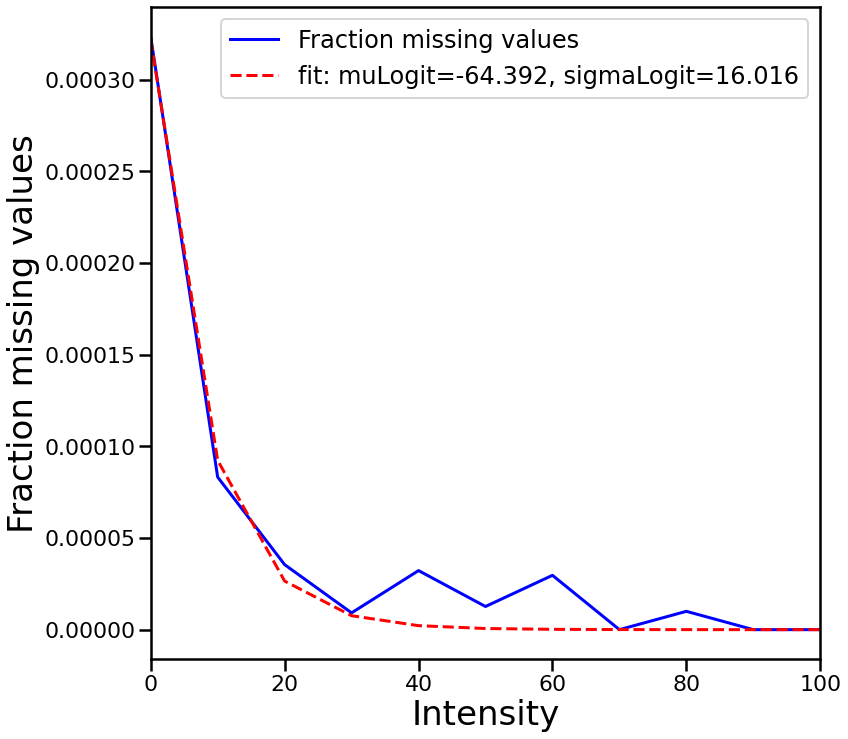

In [29]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
fig, ax = plt.subplots(1, 1, figsize=(12,12))

xdata = osw_binned_missing_value_fraction.index
ydata = osw_binned_missing_value_fraction.fraction
ax.plot(xdata, ydata, 'b-', label='Fraction missing values')


# We fit the fraction data we have to pmissings
popt, pcov = curve_fit(pmissing, xdata, ydata)

ax.plot(xdata, pmissing(xdata, popt[0], popt[1]), "r--", label='fit: muLogit=%5.3f, sigmaLogit=%5.3f' % tuple(popt))

# NOTE THIS IS NOT LOG-INTENSITY
ax.set_xlabel("Intensity", fontsize = 34)
#ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major')
#ax.set_ylabel("Fraction missing values within binned interval", fontsize = 38)
ax.set_ylabel("Fraction missing values", fontsize = 34)
ax.set_xlim(0, 100)
#ax.set_ylim(0, 0.0)
ax.legend(fontsize=24)
#ax.set_title("DIANN - Fraction Missing Values for mean intensity", fontsize = 22, fontweight = "bold")